In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [3]:
Y_train

array([4, 9, 4, ..., 9, 1, 9])

In [4]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return W1, b1, W2, b2
    #W1 = np.random.rand(10, 784) - 0.5
    #b1 = np.random.rand(10, 1) - 0.5
    #W2 = np.random.rand(10, 10) - 0.5
    #b2 = np.random.rand(10, 1) - 0.5
    #return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    Z -= np.max(Z, axis=0)  # Subtract max value for numerical stability
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A
    #A = np.exp(Z) / sum(np.exp(Z))
    #return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1 
    W2 = W2 - alpha * dW2 
    b2 = b2 - alpha * db2  
    return W1, b1, W2, b2

In [5]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 50 == 0:
            print("Iterations:", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [6]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.1, 501)

Iterations: 0
[7 7 7 ... 4 0 7] [4 9 4 ... 9 1 9]
0.06797560975609757
Iterations: 50
[4 7 4 ... 7 2 4] [4 9 4 ... 9 1 9]
0.5660975609756097
Iterations: 100
[4 9 4 ... 9 2 9] [4 9 4 ... 9 1 9]
0.7983658536585366
Iterations: 150
[4 9 4 ... 9 2 9] [4 9 4 ... 9 1 9]
0.8379512195121951
Iterations: 200
[4 9 4 ... 9 1 9] [4 9 4 ... 9 1 9]
0.8576341463414634
Iterations: 250
[4 9 4 ... 9 1 9] [4 9 4 ... 9 1 9]
0.8715365853658537
Iterations: 300
[4 9 4 ... 9 1 9] [4 9 4 ... 9 1 9]
0.8807317073170732
Iterations: 350
[4 9 4 ... 9 1 9] [4 9 4 ... 9 1 9]
0.8870731707317073
Iterations: 400
[4 9 4 ... 9 1 9] [4 9 4 ... 9 1 9]
0.8926585365853659
Iterations: 450
[4 9 4 ... 9 1 9] [4 9 4 ... 9 1 9]
0.8960487804878049
Iterations: 500
[4 9 4 ... 9 1 9] [4 9 4 ... 9 1 9]
0.8997804878048781


In [7]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [4]
Label:  4


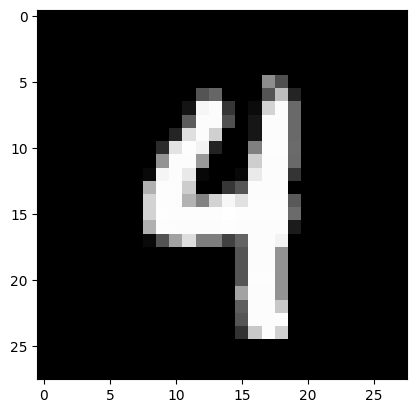

Prediction:  [9]
Label:  9


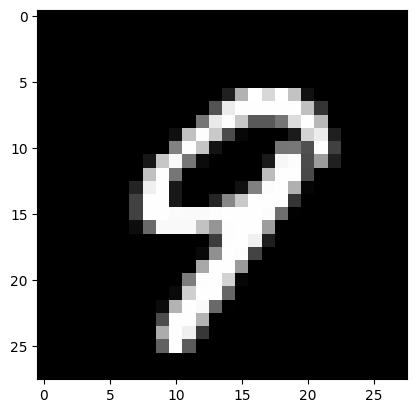

Prediction:  [4]
Label:  4


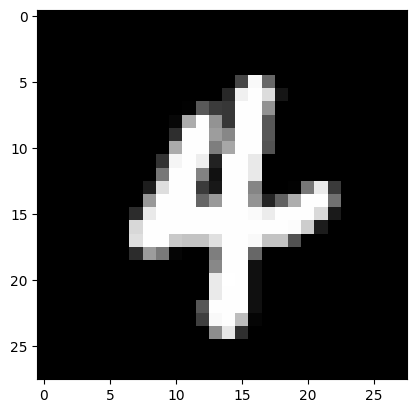

Prediction:  [8]
Label:  8


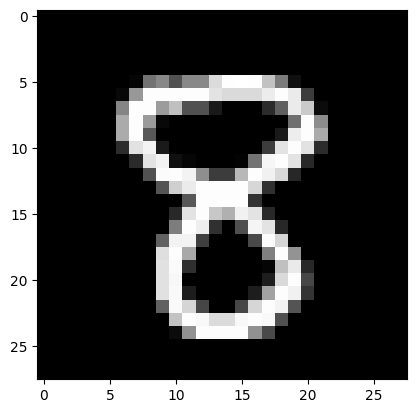

Prediction:  [9]
Label:  9


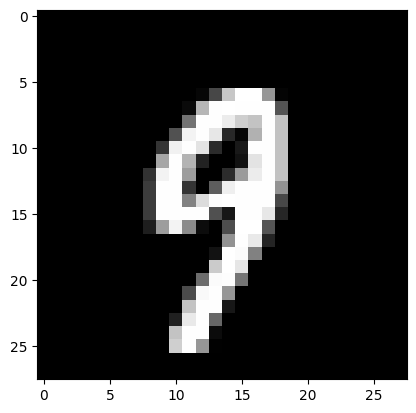

Prediction:  [9]
Label:  9


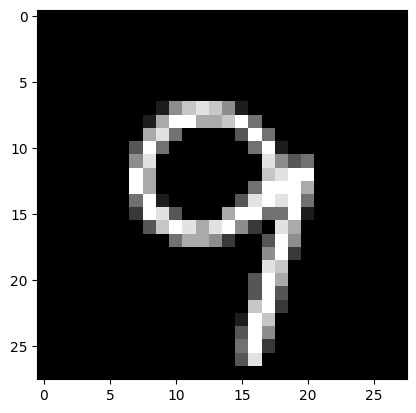

Prediction:  [7]
Label:  7


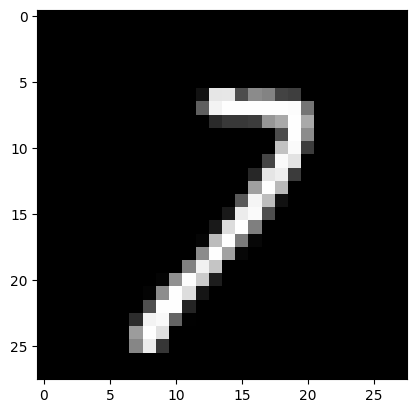

Prediction:  [1]
Label:  1


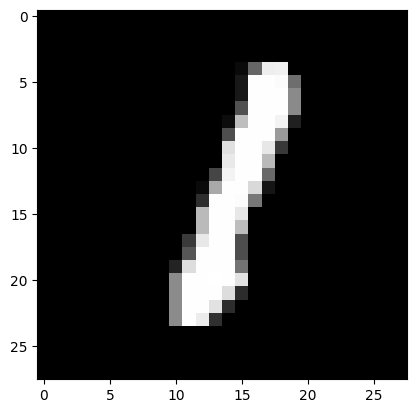

Prediction:  [9]
Label:  5


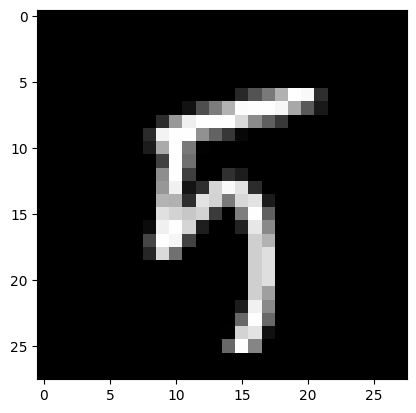

Prediction:  [0]
Label:  0


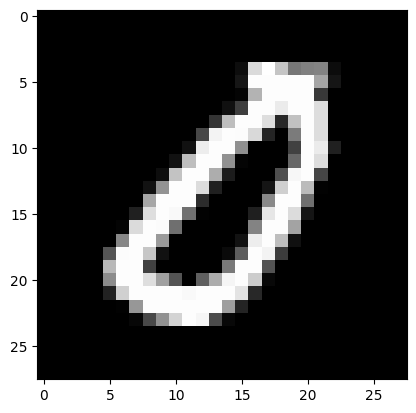

In [8]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)
test_prediction(4, W1, b1, W2, b2)
test_prediction(5, W1, b1, W2, b2)
test_prediction(6, W1, b1, W2, b2)
test_prediction(7, W1, b1, W2, b2)
test_prediction(8, W1, b1, W2, b2)
test_prediction(9, W1, b1, W2, b2)